In [591]:
import pandas as pd
from scipy.stats import poisson

In [592]:
# open `calendar.csv`
df = pd.read_csv("calendar.csv")
df.head()

,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes
0,1,Fri,2024-08-09,20:15,Sporting CP,2.9,3–1,0.5,Rio Ave,"38,513",Estádio José Alvalade,NaN,Match Report,NaN
1,1,Sat,2024-08-10,15:30,AVS Futebol,1.1,1–1,0.9,Nacional,"1,596",Estádio Clube Desportivo das Aves,NaN,Match Report,NaN
2,1,Sat,2024-08-10,18:00,Casa Pia,0.9,0–1,1.2,Boavista,"1,142",Estádio Municipal de Rio Maior,NaN,Match Report,NaN
3,1,Sat,2024-08-10,20:30,Porto,3.4,3–0,0.1,Gil Vicente FC,"46,813",Estádio Do Dragão,NaN,Match Report,NaN
4,1,Sun,2024-08-11,15:30,Estoril,0.1,1–4,3.0,Santa Clara,"1,968",Estádio António Coimbra da Mota,NaN,Match Report,NaN


In [593]:
df['Score_Home'] = df['Score'].str.split('–').str[0].astype(float, errors='ignore')
df['Score_Away'] = df['Score'].str.split('–').str[1].astype(float, errors='ignore')
df['xG_Home'] = df['xG'].fillna(0)
df['xG_Away'] = df['xG.1'].fillna(0)
df.head()

,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes,Score_Home,Score_Away,xG_Home,xG_Away
0,1,Fri,2024-08-09,20:15,Sporting CP,2.9,3–1,0.5,Rio Ave,"38,513",Estádio José Alvalade,NaN,Match Report,NaN,3.0,1.0,2.9,0.5
1,1,Sat,2024-08-10,15:30,AVS Futebol,1.1,1–1,0.9,Nacional,"1,596",Estádio Clube Desportivo das Aves,NaN,Match Report,NaN,1.0,1.0,1.1,0.9
2,1,Sat,2024-08-10,18:00,Casa Pia,0.9,0–1,1.2,Boavista,"1,142",Estádio Municipal de Rio Maior,NaN,Match Report,NaN,0.0,1.0,0.9,1.2
3,1,Sat,2024-08-10,20:30,Porto,3.4,3–0,0.1,Gil Vicente FC,"46,813",Estádio Do Dragão,NaN,Match Report,NaN,3.0,0.0,3.4,0.1
4,1,Sun,2024-08-11,15:30,Estoril,0.1,1–4,3.0,Santa Clara,"1,968",Estádio António Coimbra da Mota,NaN,Match Report,NaN,1.0,4.0,0.1,3.0


In [594]:
# Get list of teams
teams = pd.concat([df['Home'], df['Away']]).unique()
assert(len(teams) == 18)

teams

array(['Sporting CP', 'AVS Futebol', 'Casa Pia', 'Porto', 'Estoril',
       'Farense', 'Famalicão', 'Braga', 'Arouca', 'Santa Clara',
       'Gil Vicente FC', 'Rio Ave', 'Nacional', 'Benfica', 'Moreirense',
       'Vitória', 'Boavista', 'Estrela'], dtype=object)

In [595]:
# Initialize a DataFrame for the league table
league_table = pd.DataFrame({
    'Team': teams,
    'Points': 0,
    'GF': 0,
    'GA': 0
}).set_index('Team')

league_table

,Points,GF,GA
Team,,,
Sporting CP,0,0,0
AVS Futebol,0,0,0
Casa Pia,0,0,0
Porto,0,0,0
Estoril,0,0,0
Farense,0,0,0
Famalicão,0,0,0
Braga,0,0,0
Arouca,0,0,0


In [596]:
# Function to simulate a match
def simulate_match(home_xg, away_xg):
    home_goals = poisson.rvs(home_xg)
    away_goals = poisson.rvs(away_xg)
    if home_goals > away_goals:
        return home_goals, away_goals, 'Home'
    elif home_goals < away_goals:
        return home_goals, away_goals, 'Away'
    else:
        return home_goals, away_goals, 'Draw'

In [597]:
# Calculate average xG for each team at home and away
home_xg_avg = df.groupby('Home')['xG_Home'].mean()
away_xg_avg = df.groupby('Away')['xG_Away'].mean()

# Function to estimate xG for teams with missing data
def estimate_xg(home_team, away_team):
    home_xg = home_xg_avg.get(home_team, 1.0)  # Default to 1.0 if no data
    away_xg = away_xg_avg.get(away_team, 1.0)  # Default to 1.0 if no data
    return home_xg, away_xg

In [598]:
# Number of simulations
N_SIMULATIONS = 1000

# Initialize a results DataFrame
results = pd.DataFrame({
    'Team': teams,
    'Points': 0.0,
    'GF': 0.0,
    'GA': 0.0,
    'GD': 0.0
}).set_index('Team')

for _ in range(N_SIMULATIONS):
    # Temporary league table for this simulation
    temp_table = pd.DataFrame({
        'Team': teams,
        'Points': 0,
        'GF': 0,
        'GA': 0
    }).set_index('Team')
    
    for _, row in df.iterrows():
        if pd.isna(row['Score_Home']):  # Predict only for future matches
            home_xg, away_xg = estimate_xg(row['Home'], row['Away'])
            home_goals, away_goals, result = simulate_match(home_xg, away_xg)
        else:
            home_goals = row['Score_Home']
            away_goals = row['Score_Away']
            result = 'Home' if home_goals > away_goals else 'Away' if away_goals > home_goals else 'Draw'
        
        # Update the temporary league table
        temp_table.at[row['Home'], 'GF'] += home_goals
        temp_table.at[row['Away'], 'GF'] += away_goals
        temp_table.at[row['Home'], 'GA'] += away_goals
        temp_table.at[row['Away'], 'GA'] += home_goals
        
        if result == 'Home':
            temp_table.at[row['Home'], 'Points'] += 3
        elif result == 'Away':
            temp_table.at[row['Away'], 'Points'] += 3
        else:
            temp_table.at[row['Home'], 'Points'] += 1
            temp_table.at[row['Away'], 'Points'] += 1
    
    # Update the results DataFrame
    results['Points'] += temp_table['Points']
    results['GF'] += temp_table['GF']
    results['GA'] += temp_table['GA']

# Average the results
results['Points'] /= N_SIMULATIONS
results['GF'] /= N_SIMULATIONS
results['GA'] /= N_SIMULATIONS
results['GD'] = results['GF'] - results['GA']

# Sort the table by averaged points, goal difference, and goals scored
results['Points'] = results['Points'].round().astype(int)
results['GF'] = results['GF'].round().astype(int)
results['GA'] = results['GA'].round().astype(int)
results['GD'] = results['GD'].round().astype(int)
results = results.sort_values(by=['Points', 'GD', 'GF'], ascending=False)

print(results)

                Points  GF  GA  GD
Team                              
Sporting CP         70  63  22  41
Porto               68  56  19  37
Benfica             66  53  21  32
Braga               58  43  26  17
Santa Clara         52  27  26   2
Vitória             48  30  26   4
Casa Pia            43  25  28  -3
Moreirense          43  30  34  -4
Famalicão           40  26  28  -2
Gil Vicente FC      40  26  35  -8
Rio Ave             39  24  36 -12
Estrela             38  22  34 -12
Nacional            36  19  32 -13
Estoril             36  22  35 -14
AVS Futebol         34  20  34 -14
Boavista            34  18  33 -15
Farense             32  16  31 -15
Arouca              31  17  37 -20


/var/folders/pw/3lgbkgk149n6t5s78s_4n0rc0000gn/T/ipykernel_42730/40778257.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(min(results_sorted['GD'][i] - 3, -3), i, f'{gd}', va='center', fontsize=10, color='#d34242', family='SF Pro Text')


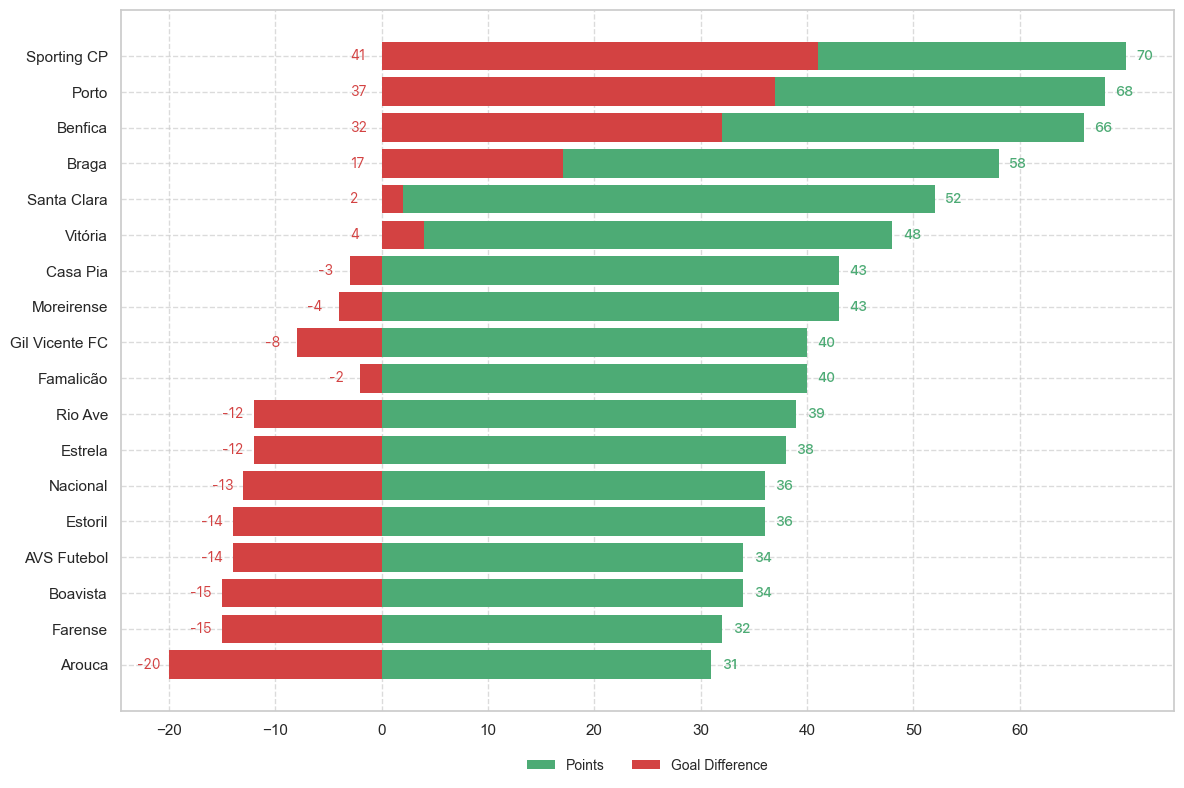

In [599]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set up the style for a minimalistic plot
sns.set(style="whitegrid")

# Sort the results by points in descending order
results_sorted = results.sort_values(by='Points', ascending=False)

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the points as bars (steelblue for a clean, minimalistic look)
bars = ax.barh(results_sorted.index, results_sorted['Points'], color='#4dab75', edgecolor='none')

# Add goal difference bars
goal_diff = ax.barh(results_sorted.index, results_sorted['GD'], color='#d34242', edgecolor='none')

# Remove gridlines and spines to keep the plot clean
# Show gridlines for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Reverse the y-axis to have the most points at the top
ax.invert_yaxis()

# Increase ticks in x axis
# Get the minimum and maximum values for the x-axis
min_x = results_sorted['GD'].min()
max_x = results_sorted['Points'].max()

# Set the ticks to be every 10 units from the minimum to the maximum
ax.xaxis.set_ticks(np.arange(min_x, max_x, 10))

# Annotate the goal difference next to the bars
for i, gd in enumerate(results_sorted['GD']):
    ax.text(min(results_sorted['GD'][i] - 3, -3), i, f'{gd}', va='center', fontsize=10, color='#d34242', family='SF Pro Text')

# Annotate the points next to the bars
for i, points in enumerate(results_sorted['Points']):
    ax.text(points + 1, i, f'{points}', va='center', fontsize=10, fontweight=500, color='#4dab75', family='SF Pro Text')

# Customize the legend
ax.legend([bars, goal_diff], ['Points', 'Goal Difference'], loc='upper center', 
          fontsize=10, frameon=False, fancybox=True, edgecolor='none', labelspacing=1.2, 
          bbox_to_anchor=(0.5, -0.05), ncol=2)  # ncol=2 to put the legend items side by side

# Show the plot
plt.tight_layout()
plt.show()


In [600]:
results_sorted

,Points,GF,GA,GD
Team,,,,
Sporting CP,70,63,22,41
Porto,68,56,19,37
Benfica,66,53,21,32
Braga,58,43,26,17
Santa Clara,52,27,26,2
Vitória,48,30,26,4
Casa Pia,43,25,28,-3
Moreirense,43,30,34,-4
Gil Vicente FC,40,26,35,-8
